## Imports

In [ ]:
import warnings
import os
import zipfile
import tensorflow as tf
from sklearn.metrics import average_precision_score

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image 
from collections import Counter
import random

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import torch
import torchvision
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F

# from torchvision.ops import box_iou
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm  
from collections import defaultdict


from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights, _utils
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection._utils import retrieve_out_channels
from torch.optim import AdamW


## Constants

In [3]:
url = "https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip"
filename = "FullIJCNN2013.zip"

data_dir = '/kaggle/working/FullIJCNN2013/FullIJCNN2013'
gt_file = '/kaggle/working/FullIJCNN2013/FullIJCNN2013/gt.txt'

annotations_file = "/kaggle/working/FullIJCNN2013/FullIJCNN2013/gt.txt"
images_dir       = "/kaggle/working/FullIJCNN2013/FullIJCNN2013"

CLASS_COUNT = 5

CLASS_TO_CATEGORY = {
    1: "prohibitory",
    2: "danger",
    3: "mandatory",
    4: "other"
}

class_mapping = {
    0: "speed limit 20 (prohibitory)",
    1: "speed limit 30 (prohibitory)",
    2: "speed limit 50 (prohibitory)",
    3: "speed limit 60 (prohibitory)",
    4: "speed limit 70 (prohibitory)",
    5: "speed limit 80 (prohibitory)",
    6: "restriction ends 80 (other)",
    7: "speed limit 100 (prohibitory)",
    8: "speed limit 120 (prohibitory)",
    9: "no overtaking (prohibitory)",
    10: "no overtaking (trucks) (prohibitory)",
    11: "priority at next intersection (danger)",
    12: "priority road (other)",
    13: "give way (other)",
    14: "stop (other)",
    15: "no traffic both ways (prohibitory)",
    16: "no trucks (prohibitory)",
    17: "no entry (other)",
    18: "danger (danger)",
    19: "bend left (danger)",
    20: "bend right (danger)",
    21: "bend (danger)",
    22: "uneven road (danger)",
    23: "slippery road (danger)",
    24: "road narrows (danger)",
    25: "construction (danger)",
    26: "traffic signal (danger)",
    27: "pedestrian crossing (danger)",
    28: "school crossing (danger)",
    29: "cycles crossing (danger)",
    30: "snow (danger)",
    31: "animals (danger)",
    32: "restriction ends (other)",
    33: "go right (mandatory)",
    34: "go left (mandatory)",
    35: "go straight (mandatory)",
    36: "go right or straight (mandatory)",
    37: "go left or straight (mandatory)",
    38: "keep right (mandatory)",
    39: "keep left (mandatory)",
    40: "roundabout (mandatory)",
    41: "restriction ends (overtaking) (other)",
    42: "restriction ends (overtaking (trucks)) (other)"
}

## Plot Functions

In [ ]:
def get_size_group(width):
    if width < 32:
        return "small"
    elif 32 <= width <= 45:
        return "medium"
    else:
        return "large"  

def classify_bbox_sizes_and_classes(dataset):
    small = {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0} 
    medium = {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0} 
    large = {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0} 

    for _, target in dataset:
        boxes = target["boxes"]
        labels = target["labels"]

        for box, label in zip(boxes, labels):
            size_group = get_size_group(width = box[2] - box[0])
            major_category = CLASS_TO_CATEGORY.get(label.item(), "other")

            if size_group == "small":
                small[major_category] += 1

            elif size_group == "medium":
                medium[major_category] += 1

            elif size_group == "large":
                large[major_category] += 1

    return { "small": small, "medium": medium, "large": large }   
    
def plot_annotations(image_path, annotations, image_number):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')

    plt.title(f"Image: {image_number}")

    for annotation in annotations:
        left, top, right, bottom, class_id = annotation
        class_name = class_mapping.get(class_id, "Unknown class")
        rect = plt.Rectangle((left, top), right-left, bottom-top, edgecolor='red', facecolor='none', linewidth=1)
        plt.gca().add_patch(rect)
        plt.text(left, top-20, class_name, color='red', fontsize=8, backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.show()

def plot_samples(data_dir, gt_file, sample_count):
    annotations = load_annotations(gt_file)
    img_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.ppm')])

    random.shuffle(img_files)
    selected_files = img_files[:sample_count]

    for img_file in selected_files:
        img_path = os.path.join(data_dir, img_file)
        image_number = img_file.split('.')[0]
        if img_file in annotations:
            plot_annotations(img_path, annotations[img_file], image_number)

def plot_bar_chart(categories, counts, title, xlabel, ylabel, group_labels=None, bar_width=0.2, legend_labels=None):
    plt.figure(figsize=(10, 6))

    if group_labels:
        x = np.arange(len(categories))
        for i, group in enumerate(group_labels):
            plt.bar(x + i * bar_width, counts[i], bar_width, label=group)
        plt.xticks(x + bar_width * (len(group_labels) - 1) / 2, categories)
    else:
        plt.bar(categories, counts, color=['blue', 'orange', 'green'])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if legend_labels:
        plt.legend(title="Class Group")

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_histogram(object_sizes):
    categories = list(object_sizes.keys())
    counts = list(object_sizes.values())
    plot_bar_chart(categories, counts, 
                   title="Object Size Distribution", 
                   xlabel="Object Size", 
                   ylabel="Count")

def plot_class_distribution(size_category_counts):
    size_groups = ["small", "medium", "large"]
    categories = ["prohibitory", "mandatory", "danger", "other"]
    bar_data = [[size_category_counts[size][cat] for size in size_groups] for cat in categories]

    plot_bar_chart(size_groups, bar_data, 
                   title="Class Distribution by Size Category", 
                   xlabel="Size Category", 
                   ylabel="Frequency", 
                   group_labels=categories, 
                   bar_width=0.2, 
                   legend_labels=categories)

def plot_class_histogram(data, title, xlabel, ylabel, color='purple'):
    categories = list(data.keys())
    counts = list(data.values())

    plt.figure(figsize=(12, 8))  # Increase figure size for better spacing
    plt.barh(categories, counts, color=color, height=0.8)  # Increase the height of bars for more spacing
    plt.xlabel(ylabel)  # Switch xlabel and ylabel for horizontal bar chart
    plt.ylabel(xlabel)
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to plot right to left
    plt.show()

def plot_map_results(map_results):
    # Convert all keys to strings and sort them
    iou_thresholds = sorted(map_results.keys(), key=lambda x: float(x))

    ap_per_class = {class_id: [] for class_id in CLASS_TO_CATEGORY.keys() if class_id != 0}

    for iou in iou_thresholds:
        for class_id, ap in map_results[iou]['AP_per_class'].items():
            if class_id != 0:  # Exclude background class
                ap_per_class[class_id].append(ap)

    mAP_values = [map_results[iou]['mAP'] for iou in iou_thresholds]

    plt.figure(figsize=(10, 6))

    for class_id, ap_values in ap_per_class.items():
        label = CLASS_TO_CATEGORY.get(class_id, f"Unknown ({class_id})")
        plt.plot(
            iou_thresholds, ap_values, label=f"{label} AP", linestyle='--', marker='o'
        )

    plt.plot(
        iou_thresholds, mAP_values, label="mAP", linestyle='-', marker='x', color='black'
    )

    if 0.75 in iou_thresholds:
        plt.axvline(x=0.75, color='purple', linestyle='--', label='IoU = 0.75')

    plt.title("AP and mAP Across IoU Thresholds", fontsize=14)
    plt.xlabel("Intersection over Union (IoU)", fontsize=12)
    plt.ylabel("Average Precision (AP)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


## Utility functions

In [24]:
def get_class_value(class_number):
    return class_mapping.get(class_number, "Unknown class number")

def load_annotations(gt_file):
    annotations = {}
    with open(gt_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split(';')
            img_file = parts[0]
            left, top, right, bottom, class_id = map(int, parts[1:])
            if img_file not in annotations:
                annotations[img_file] = []
            annotations[img_file].append((left, top, right, bottom, class_id))
    return annotations

def categorize_objects(annotations):
    object_sizes = {'small': 0, 'medium': 0, 'large': 0}
    for img_file, objs in annotations.items():
        for obj in objs:
            left, top, right, bottom, class_id = obj
            width = right - left
            if width < 32:
                object_sizes['small'] += 1
            elif 32 <= width and width < 45:
                object_sizes['medium'] += 1
            else:
                object_sizes['large'] += 1
    return object_sizes

def count_objects_by_class(annotations):
    class_counts = Counter()
    for img_file, objs in annotations.items():
        for obj in objs:
            class_id = obj[4]
            class_name = class_mapping.get(class_id, "Unknown class")
            class_counts[class_name] += 1
    return class_counts

def collate_fn(batch):
    return tuple(zip(*batch))

def split_dataset(dataset, val_ratio=0.1, test_ratio=0.2, random_state=123):
    indices = list(range(len(dataset)))
    temp_indices, test_indices = train_test_split(indices, test_size=test_ratio, random_state=random_state)
    train_indices, val_indices = train_test_split(temp_indices, test_size=val_ratio, random_state=random_state)
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset   = Subset(dataset, val_indices)
    test_dataset  = Subset(dataset, test_indices)
    return train_dataset, val_dataset, test_dataset

def get_datasets(dataset):
    train_dataset, val_dataset, test_dataset = split_dataset(dataset, val_ratio=0.1, test_ratio=0.2)
    print(f'Size of Dataset: {len(dataset)}')
    print(f'------------------------------')
    print(f'Size of Train Dataset:      {len(train_dataset)}')
    print(f'Size of Test Dataset:       {len(val_dataset)}')
    print(f'Size of Validation Dataset: {len(test_dataset)}')
    return train_dataset, val_dataset, test_dataset

def get_dataloader(dataset, shuffle, batch_size=4):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights="COCO_V1")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    return model

## Model Functions

### FRCNN

In [ ]:
def train_faster_rcnn_staged(model, train_loader, val_loader, device, rpn_epochs, roi_epochs, 
                             fine_tune_epochs, rpn_patience=4, roi_patience=4, fine_tune_patience=4, lr=1e-3):
    print("Starting staged training...")
    # Stage: Train ROI Head
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.roi_heads.parameters():
        param.requires_grad = True
    for param in model.rpn.parameters():
        param.requires_grad = False
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    run_stage(model, train_loader, val_loader, optimizer, roi_epochs, roi_patience, "ROI Head", compute_iou_loss)
    
    # Stage: Train RPN
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.roi_heads.parameters():
        param.requires_grad = False
    for param in model.rpn.parameters():
        param.requires_grad = True
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    run_stage(model, train_loader, val_loader, optimizer, rpn_epochs, rpn_patience, "RPN", compute_iou_loss)
    
    # Stage: Train ROI Head
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.roi_heads.parameters():
        param.requires_grad = True
    for param in model.rpn.parameters():
        param.requires_grad = False
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    run_stage(model, train_loader, val_loader, optimizer, roi_epochs, roi_patience, "ROI Head", calculate_map_multiclass)
    
    # Stage: Fine-tune Entire Network
    for param in model.parameters():
        param.requires_grad = True
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr) ####################################### #  * 0.1 
    run_stage(model, train_loader, val_loader, optimizer, fine_tune_epochs, fine_tune_patience, "Fine-tuning", calculate_map_multiclass)

    print("Staged training complete.")

### SSD

In [ ]:
def create_ssd_model(num_classes=5, size=300):
    model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    num_anchors = model.anchor_generator.num_anchors_per_location()
    model.head.classification_head = SSDClassificationHead(in_channels=in_channels, num_anchors=num_anchors, num_classes=num_classes)
    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model

def train_ssd_staged(model, train_loader, val_loader, device, rpn_epochs, roi_epochs, 
                             fine_tune_epochs, rpn_patience=4, roi_patience=4, fine_tune_patience=4, lr=1e-3):
    print("Starting staged training...")
    # Stage: Train ROI Head
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.roi_heads.parameters():
        param.requires_grad = True
    for param in model.rpn.parameters():
        param.requires_grad = False
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    run_stage(model, train_loader, val_loader, optimizer, roi_epochs, roi_patience, "ROI Head", compute_iou_loss)
    
    # Stage: Train RPN
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.roi_heads.parameters():
        param.requires_grad = False
    for param in model.rpn.parameters():
        param.requires_grad = True
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    run_stage(model, train_loader, val_loader, optimizer, rpn_epochs, rpn_patience, "RPN", compute_iou_loss)
    
    # Stage: Train ROI Head
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.roi_heads.parameters():
        param.requires_grad = True
    for param in model.rpn.parameters():
        param.requires_grad = False
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    run_stage(model, train_loader, val_loader, optimizer, roi_epochs, roi_patience, "ROI Head", calculate_map_multiclass)
    
    # Stage: Fine-tune Entire Network
    for param in model.parameters():
        param.requires_grad = True
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr) ####################################### #  * 0.1 
    run_stage(model, train_loader, val_loader, optimizer, fine_tune_epochs, fine_tune_patience, "Fine-tuning", calculate_map_multiclass)

    print("Staged training complete.")

### Metrics

In [ ]:
def box_iou(boxes1, boxes2):
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return torch.zeros((boxes1.size(0), boxes2.size(0)), device=boxes1.device)

    x1 = torch.max(boxes1[:, None, 0], boxes2[:, 0])  # Top-left x
    y1 = torch.max(boxes1[:, None, 1], boxes2[:, 1])  # Top-left y
    x2 = torch.min(boxes1[:, None, 2], boxes2[:, 2])  # Bottom-right x
    y2 = torch.min(boxes1[:, None, 3], boxes2[:, 3])  # Bottom-right y

    inter_width = (x2 - x1).clamp(min=0)
    inter_height = (y2 - y1).clamp(min=0)
    inter_area = inter_width * inter_height

    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])  # Area of boxes1
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])  # Area of boxes2

    union_area = area1[:, None] + area2 - inter_area
    iou = inter_area / union_area

    return iou

def early_stop(metric_values, patience):
    if not metric_values: return False
    best_metric = max(metric_values)
    best_metric_epoch = len(metric_values) - 1 - metric_values[::-1].index(best_metric)
    if len(metric_values) - best_metric_epoch - 1 >= patience:
        recent_metrics = metric_values[best_metric_epoch + 1:]
        if all(m <= best_metric for m in recent_metrics[:patience]): return True
    return False

def compute_iou_loss(model, val_loader):
    model.eval()
    total_iou = 0
    total_samples = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                pred_boxes, target_boxes = output['boxes'], target['boxes']
                if pred_boxes.numel() == 0 or target_boxes.numel() == 0:
                    # print(f"Empty boxes found. Predicted: {pred_boxes.numel()}, Target: {target_boxes.numel()}")
                    continue
                
                ious = box_iou(pred_boxes, target_boxes)                   
                if ious.numel() == 0: 
                    # print(f"No valid IoUs found between predicted and target boxes.")
                    continue
                
                mean_iou = ious.mean().item()
                if torch.isnan(torch.tensor(mean_iou)):
                    # print(f"NaN IoU found. Predicted boxes: {pred_boxes}, Target boxes: {target_boxes}")
                    continue
                
                total_iou += mean_iou
                total_samples += 1
    
    if total_samples == 0:
        print("No valid samples found in validation set for IoU computation.")
        return float('nan')  
    
    return total_iou / total_samples, None

def run_stage(model, train_loader, val_loader, optimizer, num_epochs, patience, stage_name, eval_metric_fn):
    best_metric = 0
    metric_values = []
    for epoch in range(num_epochs):
        print(f"\n{stage_name} Training - Epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        for images, targets in tqdm(train_loader, desc="Batch", leave=True, ncols=100):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}")
        
        metric_value, _ = eval_metric_fn(model, val_loader)
        metric_values.append(metric_value)
                    
        print(f"Validation Metric ({stage_name}): {metric_value}")
        
        if metric_value > best_metric:
            best_metric = metric_value
            torch.save(model.state_dict(), f"best_{stage_name.lower()}_model.pth")
            print(f"Best model for {stage_name} saved.")

        if early_stop(metric_values, patience):
            print(f"Early stopping triggered for {stage_name}.")
            break



## Metric Functoins

In [ ]:
def calculate_map_multiclass(model, val_loader, iou_thresholds=[0.5, 0.75]):
    model.eval()
    ap_scores_per_class = {iou: defaultdict(list) for iou in iou_thresholds}

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_scores = output['scores']
                pred_labels = output['labels']
                target_boxes = target['boxes']
                target_labels = target['labels']
                
                if pred_boxes.numel() == 0 or target_boxes.numel() == 0:
                    continue

                # Sort predictions by confidence score
                sorted_indices = torch.argsort(pred_scores, descending=True)
                pred_boxes = pred_boxes[sorted_indices]
                pred_scores = pred_scores[sorted_indices]
                pred_labels = pred_labels[sorted_indices]

                for iou_threshold in iou_thresholds:
                    for cls in range(1, CLASS_COUNT):
                        # Filter predictions and targets for the current class
                        cls_pred_boxes = pred_boxes[pred_labels == cls]
                        cls_pred_scores = pred_scores[pred_labels == cls]
                        cls_target_boxes = target_boxes[target_labels == cls]

                        if cls_pred_boxes.numel() == 0 and cls_target_boxes.numel() == 0:
                            continue

                        # Initialize True Positives (TP) and False Positives (FP)
                        tp = torch.zeros(len(cls_pred_boxes), dtype=torch.float32, device=device)
                        fp = torch.zeros(len(cls_pred_boxes), dtype=torch.float32, device=device)

                        if cls_target_boxes.numel() > 0:
                            matches = torch.zeros(len(cls_target_boxes), dtype=torch.bool, device=device)

                            for i, pred_box in enumerate(cls_pred_boxes):
                                
                                ious = box_iou(pred_box.unsqueeze(0), cls_target_boxes).squeeze(0)
                                max_iou, max_idx = torch.max(ious, dim=0)

                                if max_iou >= iou_threshold and not matches[max_idx]:
                                    tp[i] = 1
                                    matches[max_idx] = True
                                else:
                                    fp[i] = 1
                        else:
                            fp[:] = 1

                        # Calculate precision and recall
                        tp_cumsum = torch.cumsum(tp, dim=0)
                        fp_cumsum = torch.cumsum(fp, dim=0)
                        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
                        recalls = tp_cumsum / max(len(cls_target_boxes), 1)

                        # Append average precision score for the class
                        ap = compute_ap(precisions, recalls)
                        ap_scores_per_class[iou_threshold][cls].append(ap)

    # Compute AP per class and mAP for each IoU threshold
    map_results = {}
    for iou_threshold in iou_thresholds:
        ap_per_class = {
            cls: torch.tensor(ap_scores_per_class[iou_threshold][cls]).mean().item() if ap_scores_per_class[iou_threshold][cls] else float('nan')
            for cls in range(1, CLASS_COUNT)
        }
        map_results[iou_threshold] = {
            'AP_per_class': ap_per_class,
            'mAP': sum(ap_per_class.values()) / CLASS_COUNT
        }

    map_results['overall_mAP'] = sum(map_results[iou]['mAP'] for iou in iou_thresholds) / len(iou_thresholds)

    return map_results['overall_mAP'], map_results

def compute_ap(precisions, recalls):
    precisions = torch.cat([torch.tensor([0.], device=device), precisions, torch.tensor([0.], device=device)])
    recalls = torch.cat([torch.tensor([0.], device=device), recalls, torch.tensor([1.], device=device)])

    for i in range(precisions.size(0) - 1, 0, -1):
        precisions[i - 1] = torch.max(precisions[i - 1], precisions[i])

    indices = torch.where(recalls[1:] != recalls[:-1])[0]
    ap = torch.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap.item()


## Load Dataset

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [8]:
try:
    os.system(f"wget -O {filename} {url}")
    clear_output(wait=True)
    print(f"{filename} downloaded successfully.")
except Exception as e:
    print("An error occurred while downloading the dataset:", str(e))

FullIJCNN2013.zip downloaded successfully.


In [9]:
if os.path.exists(filename):
    try:
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("FullIJCNN2013")  
        print(f"{filename} extracted successfully.")
    except Exception as e:
        print("An error occurred while extracting the dataset:", str(e))
else:
    print(f"{filename} not found for extraction.")

FullIJCNN2013.zip extracted successfully.


In [10]:
print(f"Class {CLASS_COUNT}: {get_class_value(CLASS_COUNT)}")

Class 5: speed limit 80 (prohibitory)


In [ ]:
plot_samples(data_dir, gt_file, sample_count=3)

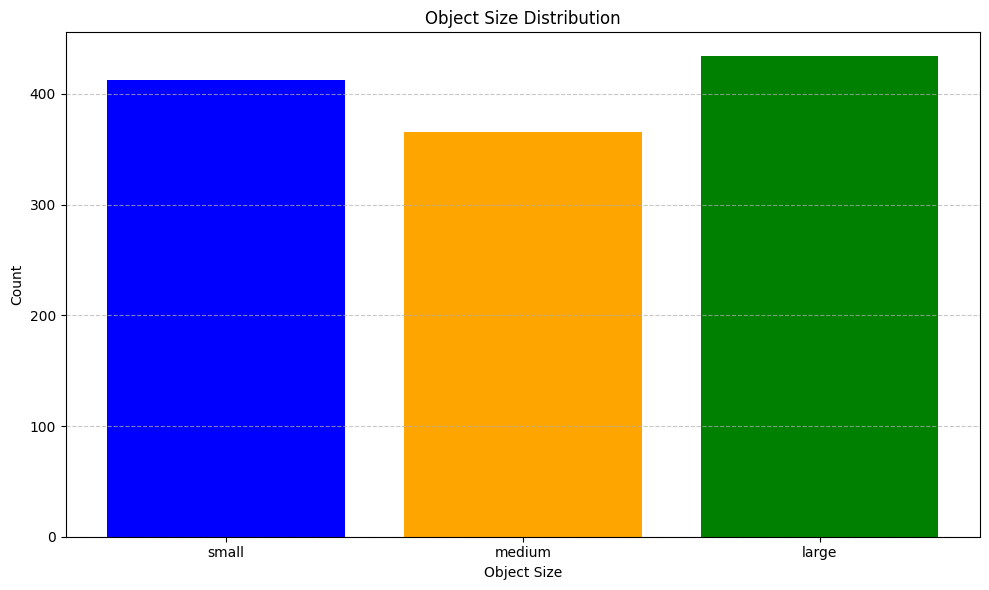

In [11]:
annotations = load_annotations(gt_file)
object_sizes = categorize_objects(annotations)
plot_histogram(object_sizes)

In [ ]:
annotations = load_annotations(gt_file)
object_sizes = categorize_objects(annotations)
plot_histogram(object_sizes)

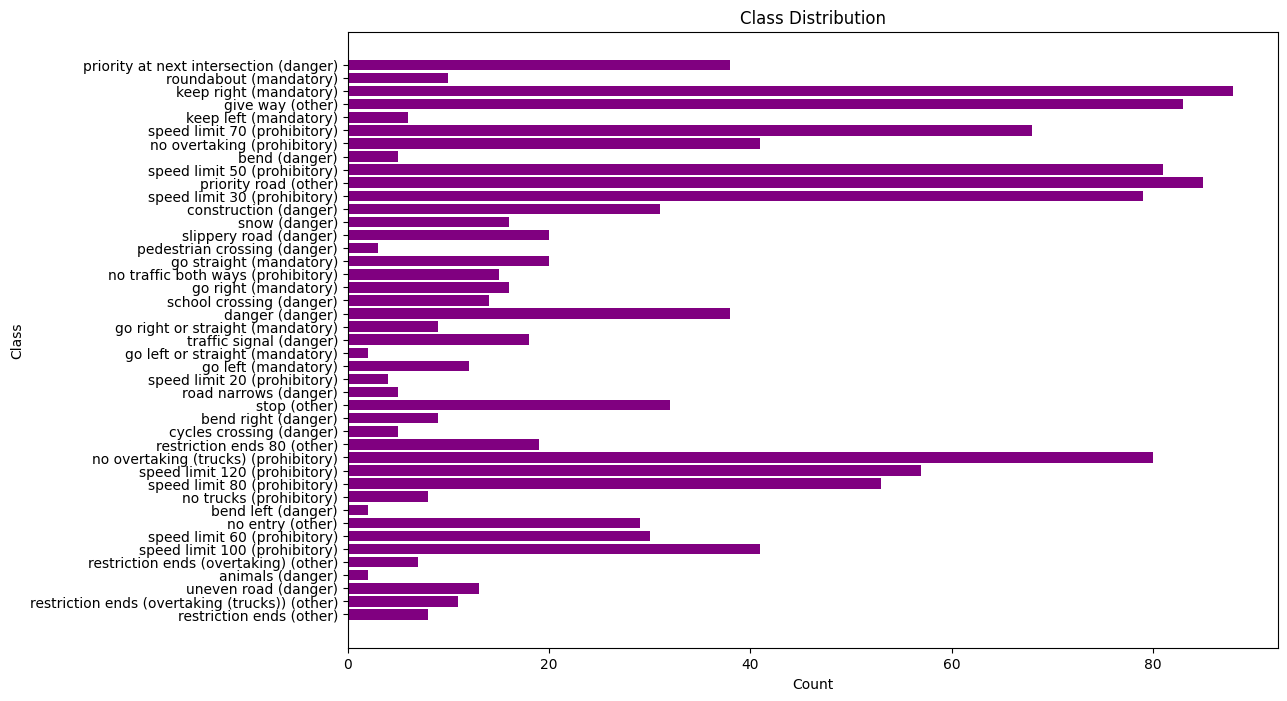

In [ ]:
class_counts = count_objects_by_class(annotations)
# plot_class_histogram(class_counts, "Class Distribution", "Class", "Count", color='purple')

## Dataset Class

In [13]:
from torch.utils.data import Dataset, Subset

class FullIJCNN2013Dataset(Dataset):
    def __init__(self, annotations_file, images_dir, transform=None):
        self.annotations = self._load_annotations(annotations_file)
        self.images_dir = images_dir
        self.transform = transform
        self.label_to_id = {
            "prohibitory": 1,
            "danger": 2,
            "mandatory": 3,
            "other": 4
        }

    def _load_annotations(self, annotations_file):
        category_mapping = {
            "prohibitory": list(range(0, 6)) + list(range(7, 11)) + [15, 16],
            "danger": list(range(18, 32)) + [11],
            "mandatory": list(range(33, 41)),
            "other": [6, 12, 13, 14, 17, 32, 41, 42]
        }

        category_lookup = {}
        for category, ids in category_mapping.items():
            for cid in ids:
                category_lookup[cid] = category

        annotations = {}
        with open(annotations_file, "r") as file:
            for line in file:
                parts = line.strip().split(";")
                img_name = parts[0]
                bbox = tuple(map(int, parts[1:5]))
                class_id = int(parts[5])
                category = category_lookup.get(class_id, "other")

                if img_name not in annotations:
                    annotations[img_name] = []
                annotations[img_name].append({"bbox": bbox, "label": category})
        return annotations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        objects = self.annotations[img_name]
        bboxes = torch.tensor([obj["bbox"] for obj in objects], dtype=torch.float32)
        labels = torch.tensor(
            [self.label_to_id[obj["label"]] for obj in objects], dtype=torch.int64
        )

        target = {
            "boxes": bboxes,
            "labels": labels
        }

        if self.transform: image = self.transform(image)

        return image, target

## Install Requirements

In [ ]:
!pip install -U pycocotools
!pip install -U faster-coco-eval
!pip install -U torchmetrics[detection]
clear_output(wait=True)
os.system('clear')

## Faser RCNN

In [ ]:
transform = T.Compose([
    T.ToTensor(),
])

dataset = FullIJCNN2013Dataset(annotations_file, images_dir, transform=transform)

In [ ]:
size_category_counts = classify_bbox_sizes_and_classes(dataset)
# plot_class_distribution(size_category_counts)

In [18]:
train_dataset, val_dataset, test_dataset = get_datasets(dataset)

Size of Dataset: 741
------------------------------
Size of Train Dataset:      532
Size of Test Dataset:       60
Size of Validation Dataset: 149


In [ ]:
# size_category_counts = classify_bbox_sizes_and_classes(train_dataset)
# plot_class_distribution(size_category_counts)

In [ ]:
# size_category_counts = classify_bbox_sizes_and_classes(test_dataset)
# plot_class_distribution(size_category_counts)

In [ ]:
# size_category_counts = classify_bbox_sizes_and_classes(test_dataset)
# plot_class_distribution(size_category_counts)

In [22]:
train_loader = get_dataloader(train_dataset, True)
val_loader = get_dataloader(val_dataset, False)
test_loader = get_dataloader(test_dataset, False)

In [ ]:
faster_rcnn_model = get_model(CLASS_COUNT).to(device)
train_faster_rcnn_staged(
    faster_rcnn_model, train_loader, val_loader, device, 
    rpn_epochs=100, roi_epochs=100, fine_tune_epochs=100, # 100
    rpn_patience=5, roi_patience=5, fine_tune_patience=5,
    lr=1e-4
)

In [28]:
stage_name = "Fine-tuning"
faster_rcnn_model.load_state_dict(torch.load(f"best_{stage_name.lower()}_model.pth", weights_only=True))
print("Evaluating...")

Evaluating...


In [29]:
test_iou_loss, _ = compute_iou_loss(faster_rcnn_model, test_loader)
print('IoU Loss: ', test_iou_loss)

IoU Loss:  0.7099245565390229


In [30]:
test_map_multiclass, map_results = calculate_map_multiclass(faster_rcnn_model, test_loader)
print('Overal MAP: ', test_map_multiclass)

Overal MAP:  0.7763962388038635


In [ ]:
# plot_map_results(map_results) # TODO fix this function

## SSD

In [ ]:
transform = T.Compose([
    T.ToTensor(),
])

ssd_dataset = FullIJCNN2013Dataset(annotations_file, images_dir, transform=transform)

train_ssd_dataset, val_ssd_dataset, test_ssd_dataset = get_datasets(ssd_dataset)

ssd_train_loader = get_dataloader(train_ssd_dataset, True)
ssd_val_loader = get_dataloader(val_ssd_dataset, False)
ssd_test_loader = get_dataloader(test_ssd_dataset, False)

Size of Dataset: 741
------------------------------
Size of Train Dataset:      532
Size of Test Dataset:       60
Size of Validation Dataset: 149


In [28]:
ssd_model = create_ssd_model().to(device)
optimizer = AdamW(ssd_model.parameters(), lr=0.0001)
num_epochs = 40

fine_tune_and_evaluate(ssd_model, train_loader, test_loader, optimizer, num_epochs, device, num_classes=num_classes)


train_ssd_staged(
    ssd_model, ssd_train_loader, ssd_val_loader, device, 
    rpn_epochs=100, roi_epochs=100, fine_tune_epochs=100, # 100
    rpn_patience=5, roi_patience=5, fine_tune_patience=5,
    lr=1e-4
)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 81.3MB/s] 


NameError: name 'fine_tune_and_evaluate' is not defined